In [2]:
# normal python
import sys
sys.path.append('/home1/jrudoler/src/')
import warnings
warnings.simplefilter('ignore')
from tqdm.notebook import tqdm
import pickle
import numpy as np
import pandas as pd
pd.options.display.max_rows = 50
pd.options.display.max_columns = None
import scipy as scp
import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['axes.labelsize'] = 16
import seaborn as sns

# lab things
import cmlreaders as cml
# from ptsa.data.filters import MorletWaveletFilter, ButterworthFilter
from ptsa.data.timeseries import TimeSeries
from ptsa.data.concat import concat
sns.set_palette('twilight')
from dask.distributed import Client, progress
import cmldask.CMLDask as da
from nicls_helpers import *

Load Subjects

In [3]:
index = cml.get_data_index("ltp")

# nsessions = index.query("experiment=='NiclsCourierReadOnly'")\
# .groupby("subject").count()['task_events'].reset_index().rename(columns={"task_events":"nsessions"})
subject_list = np.loadtxt("final_subject_list.txt", dtype=str)
# subject_list = nsessions.query("nsessions>=4")['subject'].values
# subject_list = subject_list[~np.isin(subject_list, ['LTP448', 'LTP458'])] # remove subjects with bad/missing data

## Computing features

In [13]:
da.Settings.Load("/home1/jrudoler/optimizing-memory/settings/NICLS_CL_classifier_features.pkl")

Settings(freqs=array([  6.        ,   9.75368156,  15.85571732,  25.77526961,
        41.90062864,  68.11423148, 110.72742057, 180.        ]), width=5, buffer_time=416, rel_start=-1584, rel_stop=-416, experiment='NiclsCourierClosedLoop', clean=0, save=1, reference='average')

In [14]:
# settings that specify the eeg epoch loaded (start/stop relative to stimulus onset)
# as well as other parameters for neural data processing including the frequencies for computing 
# spectral power and the width of the morlet wavelets
ro_settings = da.Settings.Load("/home1/jrudoler/optimizing-memory/settings/NICLS_RO_encoding_features.pkl")
ro_settings.rel_start = -1200
ro_settings.rel_stop = -200
ro_settings.Save("/home1/jrudoler/optimizing-memory/settings/prestimulus_NICLS_RO_encoding_features.pkl")
print("READ ONLY SETTINGS\n", ro_settings)
cl_settings = da.Settings.Load("/home1/jrudoler/optimizing-memory/settings/NICLS_CL_encoding_features.pkl")
cl_settings.rel_start = -1200
cl_settings.rel_stop = -200
cl_settings.Save("/home1/jrudoler/optimizing-memory/settings/prestimulus_NICLS_CL_encoding_features.pkl")
print("CLOSED LOOP SETTINGS\n", cl_settings)

READ ONLY SETTINGS
 rel_start: -1200
rel_stop: -200
buffer_time: 500
freqs: [  6.           9.75368156  15.85571732  25.77526961  41.90062864
  68.11423148 110.72742057 180.        ]
width: 5
experiment: NiclsCourierReadOnly
clean: 0
save: 1
reference: average
CLOSED LOOP SETTINGS
 rel_start: -1200
rel_stop: -200
buffer_time: 500
freqs: [  6.           9.75368156  15.85571732  25.77526961  41.90062864
  68.11423148 110.72742057 180.        ]
width: 5
experiment: NiclsCourierClosedLoop
clean: 0
save: 1
reference: average


In [10]:
from compute_scalp_features import compute_scalp_features

In [12]:
client = da.new_dask_client_slurm(
    job_name="NICLS_classification",
    memory_per_job="25GB",
    max_n_jobs=100,
    adapt=True
)

Unique port for jrudoler is 51360
{'dashboard_address': ':51360'}
To view the dashboard, run: 
`ssh -fN jrudoler@rhino2.psych.upenn.edu -L 8000:192.168.86.140:51360` in your local computer's terminal (NOT rhino) 
and then navigate to localhost:8000 in your browser


In [28]:
ro_futures = client.map(compute_scalp_features, subject_list, 
                        settings_path = "/home1/jrudoler/optimizing-memory/settings/prestimulus_NICLS_RO_encoding_features.pkl",
                        save_path = '/scratch/nicls_intermediate/read_only/prestimulus_encoding_powers/')

In [29]:
cl_futures = client.map(compute_scalp_features, subject_list, 
                        settings_path = "/home1/jrudoler/optimizing-memory/settings/prestimulus_NICLS_CL_encoding_features.pkl",
                        save_path = '/scratch/nicls_intermediate/closed_loop/prestimulus_encoding_powers/')

In [ ]:
CL_evs = pd.read_csv("processed_events_NiclsCourierClosedLoop.csv", index_col=0)
settings_path = "/home1/jrudoler/NICLS/NICLS_CL_encoding_features.pkl"
save_path = "/scratch/nicls_intermediate/closed_loop/encoding_powers/"
futures = []
for subject, evs in CL_evs.query("type=='WORD'").groupby("subject"):
    fut = client.submit(compute_raw_event_features, evs, subject, settings_path, save_path)
    futures.append(fut)

## Decoding memory success

In [3]:
## CML specific
client = da.new_dask_client_sge(
    job_name="NICLS_classification",
    memory_per_job="5GB",
    max_n_jobs=100,
    adapt=True
)
# client.cluster.scale(30)

## non-lab specific, can use threading / local cores instead of cluster
## set up dask client for parallel computing 
# client = Client()

Unique port for jrudoler is 51360
{'dashboard_address': ':51360'}
To view the dashboard, run: 
`ssh -fN jrudoler@rhino2.psych.upenn.edu -L 8000:192.168.86.144:51360` in your local computer's terminal (NOT rhino) 
and then navigate to localhost:8000 in your browser


In [30]:
encoding_futures = client.map(
    load_and_fit_data_encoding, 
    [f"/scratch/nicls_intermediate/read_only/prestimulus_encoding_powers/{sub}_feats.h5" for sub in subject_list],
    group="session"
)
# identical features used in univariate paper, 3 to 128 instead of 6 to 180.
# encoding_futures = client.map(load_and_fit_data_encoding, [f"/scratch/nicls_cns/final_pows/{sub}_encoding_feats.h5" 
#                                                            for sub in subject_list], group="session")

In [10]:
client.cancel(encoding_futures)

In [12]:
progress(encoding_futures)

VBox()

In [31]:
gathered_results_encoding = client.gather(encoding_futures)

In [32]:
full_results_encoding = pd.concat(gathered_results_encoding)

In [33]:
full_results_encoding.to_pickle("prestimulus_RO_classification_results_encoding.pkl")

In [25]:
full_results_encoding = pd.read_pickle("prestimulus_RO_classification_results_encoding.pkl")

### Encoding ROC

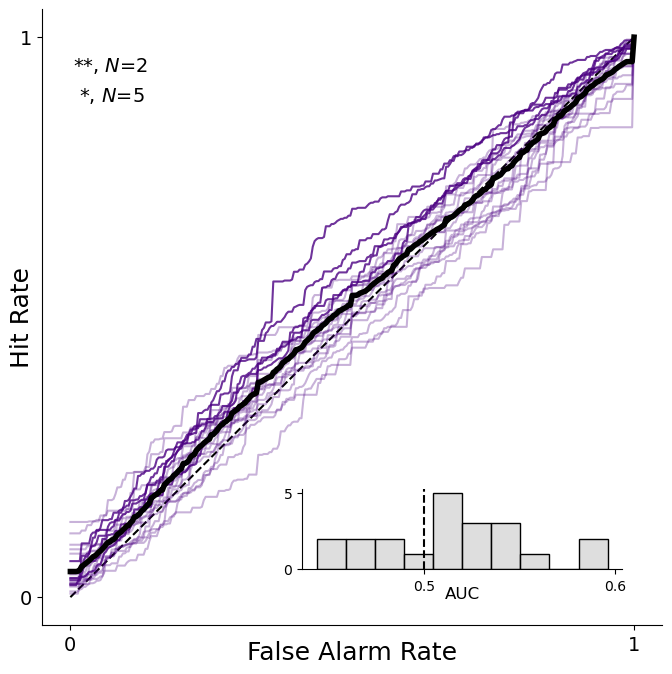

In [39]:
encoding_signif = {}
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot([0, 1], [0, 1], '--k')
base_fp = np.linspace(0, 1, 301)
tp_list = []
all_subjects_auc = []
all_subjects_null_auc = []

for subject, subject_results in full_results_encoding.groupby("subject"):
#     print(subject)
    subject_tp = []
    auc = []
    auc_null = []
    for i, row in subject_results.iterrows():
        if np.mean(row["y_true"]) in [0., 1.]:
            continue
        auc.append(row["AUC"])
        auc_null.append(row["null"])
        tp = np.interp(base_fp, row['fp'], row['tp'])
        subject_tp.append(tp)
    auc_null = np.vstack(auc_null).mean(0)
    auc = np.mean(auc)
    all_subjects_auc.append(auc)
    all_subjects_null_auc.append(np.mean(auc_null))
    p = (np.sum(auc <= auc_null)+1.)/(len(auc_null)+1.)
    encoding_signif.update({subject:p})
    if p<=0.05:
        alpha=0.8
    else:
        alpha=0.3
    tp_list.append(np.mean(subject_tp, axis=0))
    ax.plot(base_fp, np.mean(subject_tp, axis=0), color='indigo', label=f"{subject}, AUC = {row['AUC']:.3f}", alpha=alpha)

top_ax = fig.add_axes([0.45, .18, .4, .1])
auc_dist = pd.DataFrame({"subject":np.unique(full_results_encoding["subject"]), "auc":all_subjects_auc})
auc_dist['p'] = auc_dist["subject"].map(encoding_signif) 
auc_dist['signif'] = auc_dist['p']<.05
top_ax.axvline(0.5, color='k', ls='--')
sns.histplot(auc_dist, x="auc", bins=10, ax=top_ax, color='lightgrey')
top_ax.grid(False)
# top_ax.set_title('AUC', fontsize=14)
top_ax.set_xticks([.5, .6])
top_ax.spines['top'].set_visible(False)
top_ax.spines['right'].set_visible(False)
top_ax.set_xlabel('AUC', fontsize=12, labelpad=-5)
top_ax.set_ylabel('')    

ax.plot(base_fp, np.mean(np.vstack(tp_list), 0), color='k', lw = 4, alpha=1)
# ax.legend(fontsize=14, bbox_to_anchor=(1.05, 1))
ax.set_ylabel('Hit Rate', fontsize=18, labelpad=-10)
ax.set_xlabel('False Alarm Rate', fontsize=18, labelpad=-10)
ax.grid(False)
ax.tick_params(labelsize=14)
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

_ = ax.annotate(fr"**, $N$={sum(np.array(list(encoding_signif.values()))<=.01)}", xy=(.05, .9), xycoords="axes fraction", fontsize=14)
_ = ax.annotate(fr" *, $N$={sum(np.array(list(encoding_signif.values()))<=.05)}", xy=(.05, .85), xycoords="axes fraction", fontsize=14)

plt.savefig('figures/prestimulus_nested_loso_encoding.png', dpi=200, bbox_inches='tight')

In [38]:
scp.stats.ttest_1samp(full_results_encoding.groupby("subject").agg({"AUC":"mean"}), 0.5)

Ttest_1sampResult(statistic=array([1.89328413]), pvalue=array([0.07288037]))

In [36]:
mean = full_results_encoding.groupby("subject").agg({"AUC":"mean"}).mean()[0]
sem = full_results_encoding.groupby("subject").agg({"AUC":"mean"}).sem()[0]
print(f"mean AUC = {mean:.4f} +/- {sem:.4f} ")

mean AUC = 0.5163 +/- 0.0086 


### One-list normalization for closed loop

  0%|          | 0/21 [00:00<?, ?it/s]

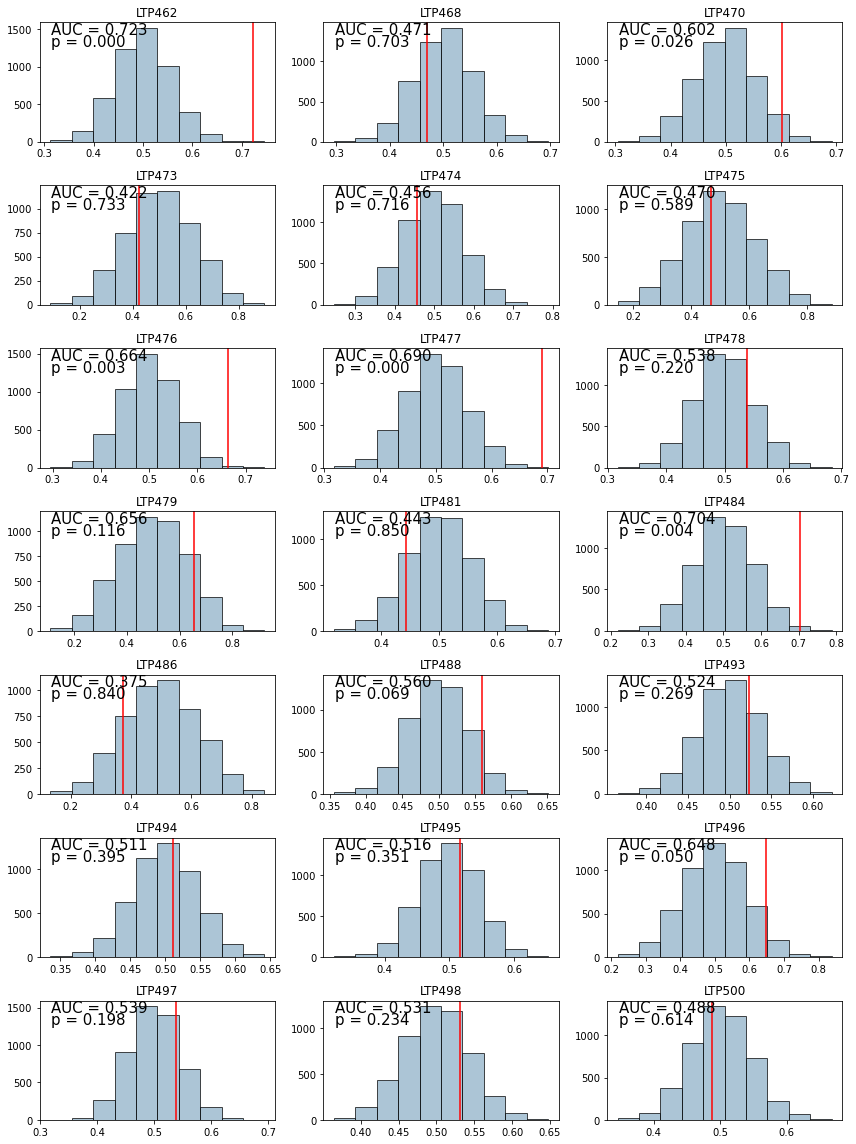

In [20]:
path = '/scratch/nicls_intermediate/closed_loop/encoding_powers/'
base_fp = np.linspace(0, 1, 301)

fig, ax = plt.subplots(len(subject_list) // 3 + len(subject_list) % 3, 3, figsize=(12, 16))
ax = ax.ravel()
cl_result_dict = {}
# behavioral events with classifier information integrated
CL_evs = pd.read_csv("processed_events_NiclsCourierClosedLoop.csv", index_col=0)

session_level_results = {}

for i, subject in tqdm(list(enumerate(subject_list))):
    ts = TimeSeries.from_hdf(path+subject+"_raw_feats.h5", engine="netcdf4")
    evs = CL_evs.query(f'type=="WORD"&subject=="{subject}"').reset_index()
    
    ts = ts.groupby('session').apply(norm_sess_feats, n_lists=1)
    
    model = ClassifierModel(
        LogisticRegression(),
        sklearn_version=sklearn_version
    ).load_json(f"/data/eeg/scalp/ltp/NiclsCourierReadOnly/{subject}/nicls_{subject}_classifier.json").model
    evs = evs.query('trial_type in ["Sham", "NoStim"]')
    sham_powers = ts.isel(event=evs.index)
    auc = []
    auc_null = []
    subject_tp = []
    session_level_results[subject] = {}
    for sess, sess_pows in sham_powers.groupby("session"): 
        prob = model.predict_proba(sess_pows.data)[:, 1]
        if np.mean(sess_pows.recalled.values) in [0., 1.]:
            continue
        fp, tp, _ = roc_curve(sess_pows.recalled.values, prob)
        tp = np.interp(base_fp, fp, tp)
        subject_tp.append(tp)
        score, null, p_val = post_hoc_permutation(y_true=sess_pows.recalled.values, y_score = prob)
        session_level_results[subject][sess] = (score, null, p_val)
        auc.append(score)
        auc_null.append(null)
    auc_null = np.vstack(auc_null).mean(0)
    auc = np.mean(auc)
    p = (np.sum(auc <= auc_null)+1.)/(len(auc_null)+1.)
    cl_result_dict[subject] = (fp, np.mean(subject_tp, axis=0), auc, auc_null)
    
    ax[i].set_title(subject)
    ax[i].hist(auc_null, ec='k', alpha=.7)
    ax[i].axvline(auc, c='r')
    ax[i].annotate(f'p = {p:.3f}', xy=(.05, .8), xycoords='axes fraction', fontsize=15)
    ax[i].annotate(f'AUC = {auc:.3f}', xy=(.05, .9), xycoords='axes fraction', fontsize=15)
plt.tight_layout()

In [11]:
with open(f"CL_classification_results_encoding.pkl", "wb") as f:
    pickle.dump(cl_result_dict, f)
df_session_results = pd.DataFrame(session_level_results).melt(var_name="subject")
df_session_results[["score", "perm_scores", "pval"]] = df_session_results['value'].apply(pd.Series)
df_session_results = df_session_results.dropna().drop(columns=["value"])
df_session_results["session"] = df_session_results.groupby("subject").cumcount()
df_session_results.to_pickle("CL_session_classification_results.pkl")
df_session_results

In [19]:
df_session_results = pd.read_pickle("CL_session_classification_results.pkl")

In [27]:
scp.stats.ttest_1samp(df_session_results.groupby("subject").agg({"score":"mean"}), 0.5)

Ttest_1sampResult(statistic=array([2.26357484]), pvalue=array([0.03487622]))

In [26]:
mean = df_session_results.groupby("subject").agg({"score":"mean"}).mean()[0]
sem = df_session_results.groupby("subject").agg({"score":"mean"}).sem()[0]
print(f"mean AUC = {mean:.4f} +/- {sem:.4f} ")

mean AUC = 0.5491 +/- 0.0217 


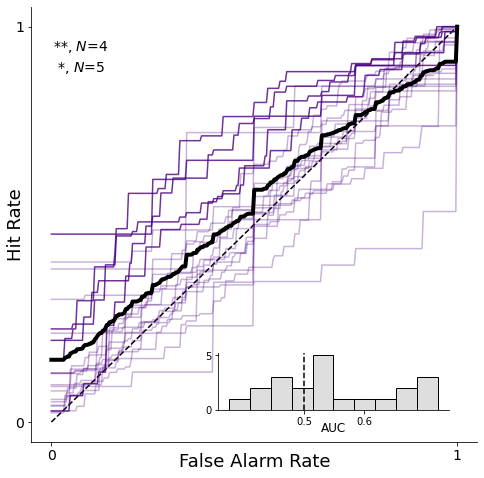

In [23]:
with open(f"CL_classification_results_encoding.pkl", "rb") as f:
    cl_result_dict = pickle.load(f)
encoding_signif = {}
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot([0, 1], [0, 1], '--k')
base_fp = np.linspace(0, 1, 301)
tp_list = []
all_subjects_auc = []
all_subjects_null_auc = []

for subject in cl_result_dict:
#     print(subject)
    (fp, tp, auc, auc_null) = cl_result_dict[subject]
    all_subjects_auc.append(auc)
    all_subjects_null_auc.append(np.mean(auc_null))
    p = (np.sum(auc <= auc_null)+1.)/(len(auc_null)+1.)
    encoding_signif.update({subject:p})
    if p<=0.05:
        alpha=0.8
    else:
        alpha=0.3
    tp_list.append(tp)
    ax.plot(base_fp, tp, color='indigo', label=f"{subject}, AUC = {row['AUC']:.3f}", alpha=alpha)

top_ax = fig.add_axes([0.45, .18, .4, .1])
auc_dist = pd.DataFrame({"subject":np.array([s for s in cl_result_dict]), "auc":all_subjects_auc})
auc_dist['p'] = auc_dist["subject"].map(encoding_signif) 
auc_dist['signif'] = auc_dist['p']<.05
top_ax.axvline(0.5, color='k', ls='--')
sns.histplot(auc_dist, x="auc", bins=10, ax=top_ax, color='lightgrey')
top_ax.grid(False)
# top_ax.set_title('AUC', fontsize=14)
top_ax.set_xticks([.5, .6])
top_ax.spines['top'].set_visible(False)
top_ax.spines['right'].set_visible(False)
top_ax.set_xlabel('AUC', fontsize=12, labelpad=-5)
top_ax.set_ylabel('')    

ax.plot(base_fp, np.mean(np.vstack(tp_list), 0), color='k', lw = 4, alpha=1)
# ax.legend(fontsize=14, bbox_to_anchor=(1.05, 1))
ax.set_ylabel('Hit Rate', fontsize=18, labelpad=-10)
ax.set_xlabel('False Alarm Rate', fontsize=18, labelpad=-10)
ax.grid(False)
ax.tick_params(labelsize=14)
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

_ = ax.annotate(fr"**, $N$={sum(np.array(list(encoding_signif.values()))<=.01)}", xy=(.05, .9), xycoords="axes fraction", fontsize=14)
_ = ax.annotate(fr" *, $N$={sum(np.array(list(encoding_signif.values()))<=.05)}", xy=(.05, .85), xycoords="axes fraction", fontsize=14)

plt.savefig('CL_nested_loso_encoding.pdf', dpi=200, bbox_inches='tight')

In [16]:
CL_evs = pd.read_csv("processed_events_NiclsCourierClosedLoop.csv", index_col=0)
# CL_evs = CL_evs[~(CL_evs['classifier duration']>=6)]
# drop events with intermediate wait times
# CL_evs = CL_evs[(CL_evs['wait_time']<=50)|(CL_evs['wait_time']>=5000)|(CL_evs['trial_type']=='Sham')]
# CL_evs = CL_evs[(CL_evs['wait_time']<=50)|(CL_evs['trial_type']=='Sham')]
recall_by_cond = CL_evs.query("type=='WORD' and trial_type in ['Neg', 'Pos', 'Sham']").groupby(["subject", "session", "trial_type"]).agg({"recalled":np.nanmean, "probability":np.nanmean}).reset_index()
recall_by_cond

,subject,session,trial_type,recalled,probability
0,LTP462,0,Neg,0.333333,0.485012
1,LTP462,0,Pos,0.666667,0.504499
2,LTP462,0,Sham,0.300000,0.487880
3,LTP462,1,Neg,0.622222,0.485941
4,LTP462,1,Pos,0.488889,0.505100
...,...,...,...,...,...
199,LTP500,2,Pos,0.666667,0.938249
200,LTP500,2,Sham,0.600000,0.671470
201,LTP500,3,Neg,0.777778,0.174701
202,LTP500,3,Pos,0.688889,0.946089


In [ ]:
for g, df in CL_evs.groupby("subject"):
    df = df.query("type=='WORD' and trial_type in ['Neg', 'Pos', 'Sham']").groupby(["subject", "session", "trial_type"]).agg({"recalled":np.nanmean, "probability":np.nanmean}).reset_index()

In [10]:
corr_df = recall_by_cond.groupby(["trial_type", "subject"], as_index=False).mean()

In [12]:
for g, df in corr_df.groupby("trial_type"):
    print(g, np.corrcoef(df["probability"], df["recalled"]))

Neg [[ 1.         -0.11058394]
 [-0.11058394  1.        ]]
Pos [[ 1.         -0.06477101]
 [-0.06477101  1.        ]]
Sham [[ 1.        -0.3125485]
 [-0.3125485  1.       ]]


In [80]:
matched_predictions = pd.read_csv("classifier_events_with_matched_predictions.csv", index_col=0)
# matched_predictions = matched_predictions[(matched_predictions['wait_time']<=50)|(matched_predictions['trial_type']=='Sham')]
matched_recall_by_cond = matched_predictions.query("matched_predictions and trial_type in ['Neg', 'Pos', 'Sham']").groupby(["subject", "session", "trial_type"]).agg({"recalled":np.nanmean, "probability":np.nanmean}).reset_index()
matched_recall_by_cond

,subject,session,trial_type,recalled,probability
0,LTP462,0,Neg,0.333333,0.482306
1,LTP462,0,Pos,0.685714,0.505035
2,LTP462,0,Sham,0.360000,0.485794
3,LTP462,1,Neg,0.571429,0.483281
4,LTP462,1,Pos,0.607143,0.505588
...,...,...,...,...,...
197,LTP500,2,Pos,0.750000,0.942167
198,LTP500,2,Sham,0.750000,0.834452
199,LTP500,3,Neg,0.766667,0.185440
200,LTP500,3,Pos,0.689655,0.987861


In [81]:
performance_stats = pd.read_csv("system_performance_stats_FR_only.csv", header=[0, 1], index_col=[0, 1])
print(f"Losing {performance_stats['bad_session'].values.sum()} sessions with bad system performance")
recall_by_cond = pd.concat([recall_by_cond.groupby(["subject", "session"]).get_group(g) for g in performance_stats[~performance_stats['bad_session'].values].index])
matched_recall_by_cond = pd.concat([matched_recall_by_cond.groupby(["subject", "session"]).get_group(g) for g in performance_stats[~performance_stats['bad_session'].values].index])

Losing 7 sessions with bad system performance


In [86]:
scores = []
pvals = []
for i, row in recall_by_cond.iterrows():
    try:
        scores.append(df_session_results.query(f"subject=='{row['subject']}' and session=={row['session']}")["score"].values[0])
        pvals.append(df_session_results.query(f"subject=='{row['subject']}' and session=={row['session']}")["pval"].values[0])
    except IndexError:
        scores.append(None)
        pvals.append(None)
recall_by_cond["score"] = np.array(scores)
recall_by_cond["pval"] = np.array(pvals)
recall_by_cond.dropna(subset=["score", "pval"], inplace=True)
# recall_by_cond["trial_code"] = recall_by_cond["trial_type"].map({"Neg":0, "Sham":1, "Pos":2})
# recall_by_cond["signif.05"] = recall_by_cond["pval"]<=.05
# recall_by_cond["signif.1"] = recall_by_cond["pval"]<=.1
# matched_recall_by_cond["score"] = np.array(scores)
# matched_recall_by_cond["pval"] = np.array(pvals)
# matched_recall_by_cond.dropna(subset=["score", "pval"], inplace=True)

In [89]:
recall_by_cond.to_csv("data/memory_improvement_data.csv", index=False)
# matched_recall_by_cond.to_csv("data/posthoc_filtered_memory_improvement_data.csv", index=False)

## Full-session Normalization

  0%|          | 0/21 [00:00<?, ?it/s]

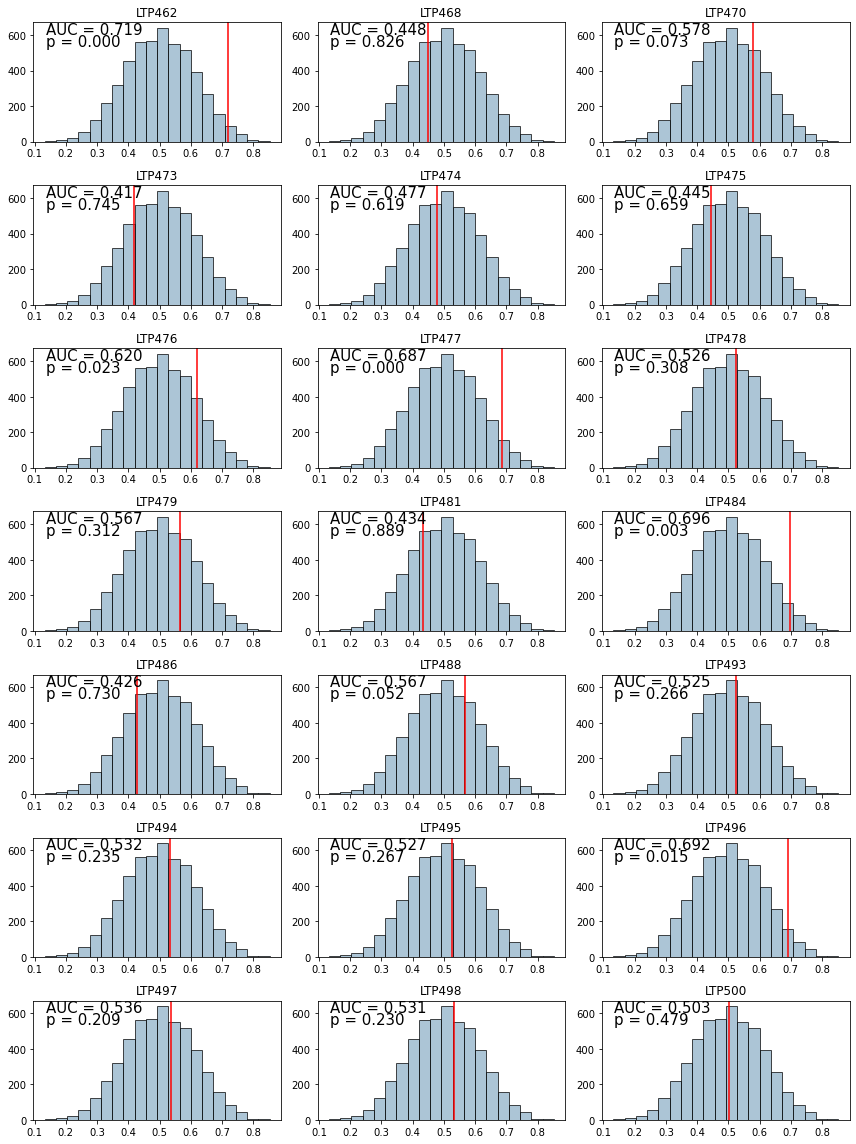

In [36]:
from scipy.stats import zscore
path = '/scratch/nicls_intermediate/closed_loop/encoding_powers/'
base_fp = np.linspace(0, 1, 301)

fig, ax = plt.subplots(len(subject_list) // 3 + len(subject_list) % 3, 3, figsize=(12, 16))
ax = ax.ravel()
cl_result_dict = {}
CL_evs = pd.read_csv("processed_events_NiclsCourierClosedLoop.csv", index_col=0)

for i, subject in tqdm(list(enumerate(subject_list))):
    ts = TimeSeries.from_hdf(path+subject+"_raw_feats.h5", engine="netcdf4")
    evs = CL_evs.query(f'type=="WORD"&subject=="{subject}"').reset_index()
    
    ts = ts.groupby('session').reduce(func=zscore, dim='event', keep_attrs=True, ddof=1)
    
    model = ClassifierModel(
        LogisticRegression(),
        sklearn_version=sklearn_version
    ).load_json(f"/data/eeg/scalp/ltp/NiclsCourierReadOnly/{subject}/nicls_{subject}_classifier.json").model
    evs = evs.query('trial_type in ["Sham", "NoStim"]')
    sham_powers = ts.isel(event=evs.index)
    auc = []
    auc_null = []
    subject_tp = []
    for sess, sess_pows in sham_powers.groupby("session"): 
        prob = model.predict_proba(sess_pows.data)[:, 1]
        if np.mean(sess_pows.recalled.values) in [0., 1.]:
            continue
        fp, tp, _ = roc_curve(sess_pows.recalled.values, prob)
        tp = np.interp(base_fp, fp, tp)
        subject_tp.append(tp)
        score, null, p_val = post_hoc_permutation(y_true=sess_pows.recalled.values, y_score = prob)
        auc.append(score)
        auc_null.append(null)
    auc_null = np.vstack(auc_null).mean(0)
    auc = np.mean(auc)
    p_val = (np.sum(auc <= auc_null)+1.)/(len(auc_null)+1.)
    cl_result_dict[subject] = (fp, np.mean(subject_tp, axis=0), auc, auc_null)
    
    ax[i].set_title(subject)
    ax[i].hist(auc_results, ec='k', alpha=.7, bins=20)
    ax[i].axvline(auc, c='r')
    ax[i].annotate(f'p = {p_val:.3f}', xy=(.05, .8), xycoords='axes fraction', fontsize=15)
    ax[i].annotate(f'AUC = {auc:.3f}', xy=(.05, .9), xycoords='axes fraction', fontsize=15)
plt.tight_layout()

Text(0.5, 0, 'Predicted Probability')

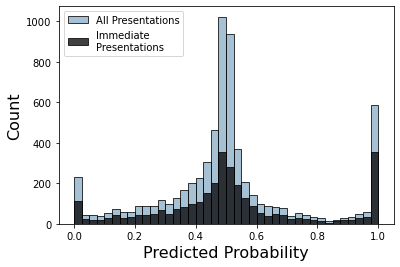

In [34]:
plt.rcParams['figure.facecolor']='white'
sns.histplot(data=CL_evs.query("type=='WORD' & trial_type!='NoStim'"), x="probability", bins=40, label='All Presentations')
sns.histplot(data=CL_evs.query("type=='WORD' & trial_type!='NoStim' & wait_time<=50"), x="probability", bins=40, color='k', label='Immediate\nPresentations')
plt.legend(loc=2)
plt.xlabel("Predicted Probability")